<a href="https://colab.research.google.com/github/Luke-687/Chemotaxis-With-RL/blob/main/ChemoTaxis2Actions_(Improved_mapping).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import matplotlib.pyplot as plt
import random
import math

#Thinking of states as bad-->bad, bad-->good, good-->bad, good-->good in which past actions will help inform future actions
#Say we move from good-->good, then the action which brought us to do so will be favored once more.
#split into 3 possible actions, in which the entity can move in 120 degree sections of a full circle, moving 1-3 steps at a time

#States good and bad refer to perceived position based on chemicals
states = ["good", "bad"]

actions = {
    "good": [1,2],
    "bad":[1,2]
}

rGood = 15
rBad = -10

pGoodGood1 = 0.50
pGoodBad1 = 0.50

pGoodGood2 = 0.50
pGoodBad2 = 0.50

pBadGood1 = 0.50
pBadBad1 = 0.50

pBadGood2 = 0.50
pBadBad2 = 0.50

transitions = {
    ("good",1): [("good",pGoodGood1,rGood), ("bad",pGoodBad1,rBad)],
    ("good",2): [("good",pGoodGood2,rGood),("bad",pGoodBad2,rBad)],
    ("bad",1): [("good",pBadGood1,rGood),("bad",pBadBad1,rBad)],
    ("bad",2): [("good",pBadGood2,rGood),("bad",pBadBad2,rBad)],
}

In [36]:
def calcReward(color):
  if(color == "green"):
    return rGood*1
  elif(color == "yellow"):
    return rGood*0.5
  else:
    return -10

def gradients():
  #center of good chemical is (10,10)
  XYColorAlpha = []
  for j in range(0,20):
    for i in range(0,20):
      distanceFromSource = math.sqrt((j-10)**2+(i-10)**2)
      if(distanceFromSource<=8 and not (distanceFromSource==0)):
        XYColorAlpha.append([i,j,"green", 1/distanceFromSource,10/distanceFromSource])
      elif(distanceFromSource==0):
        XYColorAlpha.append([i,j,"green", 1,10])
      else:
        XYColorAlpha.append([i,j,"green", 0, -10])
  x=[]
  y=[]
  color=[]
  alphaG=[]
  rewardG=[]
  for item in XYColorAlpha:
    x.append(item[0])
    y.append(item[1])
    color.append(item[2])
    alphaG.append(item[3])
    rewardG.append(item[4])
  return x,y,color,alphaG,rewardG

def fixProb(move, currentState, newState, pGoodGood1, pGoodBad1, pBadBad1, pBadGood1, pGoodGood2, pGoodBad2, pBadBad2, pBadGood2,c):
  transitions = {}
  if(move ==1):
    if(currentState == "good"):
      if(newState =="good"):
        pGoodGood1 +=c
        pGoodBad1-=c
        if(pGoodBad1<0):
          pGoodBad1=0
      else:
        pGoodGood1 -=c
        pGoodBad1+=c
        if(pGoodGood1<0):
          pGoodGood1=0
    else:
      if(newState == "good"):
        pBadGood1 +=c
        pBadBad1-=c
        if(pBadBad1<0):
          pBadBad1 =0
      else:
        pBadBad1+=c
        pBadGood1-=c
        if(pBadGood1<0):
          pBadGood1=0
  else:
    if(currentState == "good"):
      if(newState =="good"):
        pGoodGood2 +=c
        pGoodBad2-=c
        if(pGoodBad2<0):
          pGoodBad2=0
      else:
        pGoodGood2 -=c
        pGoodBad2+=c
        if(pGoodGood2<0):
          pGoodGood2=0
    else:
      if(newState == "good"):
        pBadGood2 +=c
        pBadBad2-=c
        if(pBadBad2<0):
          pBadBad2 =0
      else:
        pBadBad2+=c
        pBadGood2-=c
        if(pBadGood2<0):
          pBadGood2=0

  # Update the transitions dictionary with the new probabilities
  transitions[("good", 1)] = [("good", pGoodGood1, rGood), ("bad", pGoodBad1, rBad)]
  transitions[("good", 2)] = [("good", pGoodGood2, rGood), ("bad", pGoodBad2, rBad)]
  transitions[("bad", 1)] = [("good", pBadGood1, rGood), ("bad", pBadBad1, rBad)]
  transitions[("bad", 2)] = [("good", pBadGood2, rGood), ("bad", pBadBad2, rBad)]

  return transitions

#define environmet
xGradient, yGradient, colors, alphaG, rewardG = gradients()

In [37]:
#Idea: given a state starting at 0,0, read the gradients from the graph of points, doing so essentially based on 4 different colors split up by proximity to target
#After reading the gradient, decide if it's good or bad, assume you begin at a bad state essential every time.
#Start with a random action from 0,0, and evalute the position it brings you to from there, use the gradient of this position to determine if you went from b->g, or whatever it is
#Knowing you went from one state to another, evaluate the probability for that state, increase probability of something good coming out of that movement
#Meaning say you started at bad and moved to good using move 1, then increase the probability of bad using move 1 will lead to something good, say increase by 0.1 and decear bad using move 1 leads to bad by -0.1

#Run bellman equation for each new step, but first to set up initial values

#Initial policy:
V = {s: 0 for s in states}
policy = {s: None for s in states}
for s in states:
    actVals = {}
    for a in actions[s]:
      tot = 0
      for (s_next, prob, reward) in transitions[(s, a)]:
        tot += prob * (reward + 0.9 * V[s_next])
      actVals[a] = tot
    maxAct = max(actVals, key = actVals.get)
    V[s] = actVals[maxAct]
    policy[s] = maxAct

#Run it for a number of steps, begin with the policy defined above and then redifine policy at each step
#How many steps by agent:
steps = 50

currentX = 0
currentY = 0
x = [0]
y = [0]

#Loop through for n number of steps:
for i in range(0, steps):
  # Ensure currentX and currentY stay within bounds
  currentX = max(0, min(currentX, 19))
  currentY = max(0, min(currentY, 19))

  currentReward = rewardG[currentX+currentY*20]
  if(currentReward>0):
    currentState = "good"
  else:
    currentState = "bad"

  #Refine the policy based on current state
  actVals = {} # Initialize actVals here
  for a in actions[currentState]:
    tot = 0
    #alter reward in bellman, consider current reward sate and multiply by 0.8 for lack of confidence
    for(s_next, prob, reward) in transitions[(currentState, a)]:
      tot += prob * (currentReward*0.8 + 0.9 * V[s_next])
    actVals[a] = tot
  if actVals: #Check that actVals has actual values
      maxAct = max(actVals, key = actVals.get)
      V[currentState] = actVals[maxAct]
      policy[currentState] = maxAct
  else:
      maxAct = random.choice(actions[currentState]) #Random action if it doesnt find something in actVals
      policy[currentState] = maxAct

  #Define the move being made by agent:
  move = policy[currentState]
  if(move == 1):
    currentX+= random.randint(-1,1)
    currentY+= random.randint(0,1)
  elif(move == 2):
    currentX+= random.randint(-1,1)
    currentY+= random.randint(-1,0)
  x.append(currentX)
  y.append(currentY)
  #New position below
  currentX = max(0, min(currentX, 19))
  currentY = max(0, min(currentY, 19))
  newState = colors[(currentX+currentY*20)]
  if(calcReward(newState)>0):
    newState = "good"
  else:
    newState = "bad"

  #redifine transitionProbs, c is prob change
  c = 0.9
  transitions = fixProb(move, currentState, newState, pGoodGood1, pGoodBad1, pBadBad1, pBadGood1, pGoodGood2, pGoodBad2, pBadBad2, pBadGood2,c)

[0, -1, 0, 0, 1, 2, 3, 4, 4, 4, 3, 3, 2, 3, 2, 1, 1, 0, -1, -1, 1, 1, 2, 3, 3, 3, 2, 2, 2, 2, 2, 3, 4, 5, 6, 5, 6, 7, 7, 6, 7, 6, 6, 6, 7, 8, 8, 7, 7, 8, 7]
[0, 1, 1, 1, 1, 2, 2, 3, 4, 5, 6, 6, 6, 6, 6, 6, 7, 8, 9, 10, 11, 12, 12, 13, 14, 15, 14, 13, 13, 12, 11, 11, 11, 11, 11, 12, 12, 11, 12, 12, 13, 14, 13, 13, 12, 13, 12, 11, 11, 10, 10]


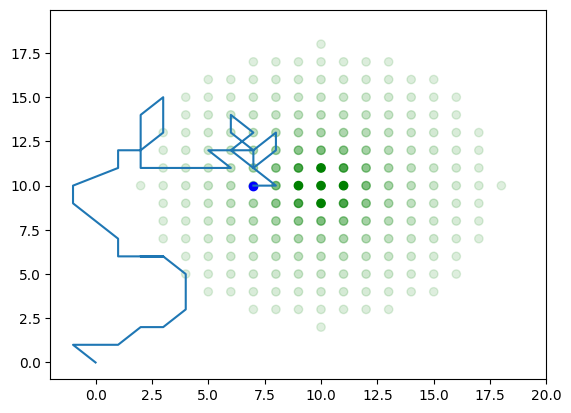

In [38]:
#Visualize using x pos, y pos, and the initial blob of positive particles
print(x)
print(y)
plt.scatter(xGradient, yGradient, c= colors, alpha=alphaG)
plt.plot(x,y)
plt.scatter(x[-1], y[-1], c="blue")